<a href="https://colab.research.google.com/github/ariqnurcahyo/smart_cane/blob/main/langsung_pake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
%rm -rf darknet

/content


In [2]:
# Clone versi resmi yang cocok untuk Colab
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet

# Aktifkan GPU, CUDNN, dan OpenCV di Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

# Compile
!make

Cloning into 'darknet'...
remote: Enumerating objects: 15900, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 15900 (delta 20), reused 6 (delta 6), pack-reused 15869 (from 2)
Receiving objects: 100% (15900/15900), 14.47 MiB | 9.01 MiB/s, done.
Resolving deltas: 100% (10704/10704), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function â€˜void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)â€™:
./src/image_opencv.cpp:945:23: warning:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/file_weight/custom-yolov4-tiny-detector_best.weights /content/

<IPython.core.display.Javascript object>

âœ… Foto disimpan ke camera_capture.jpg


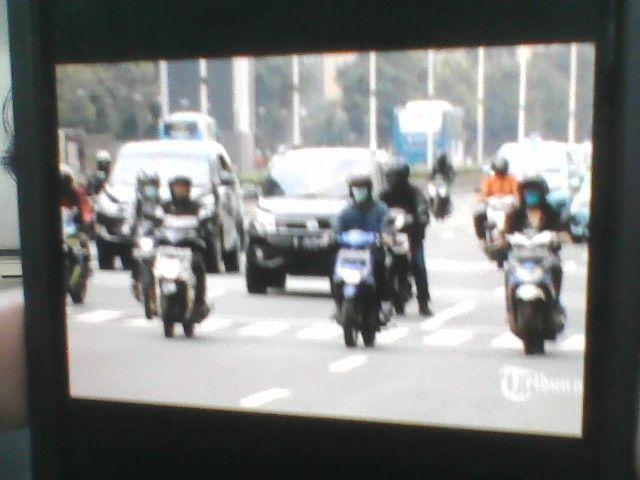

 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	   

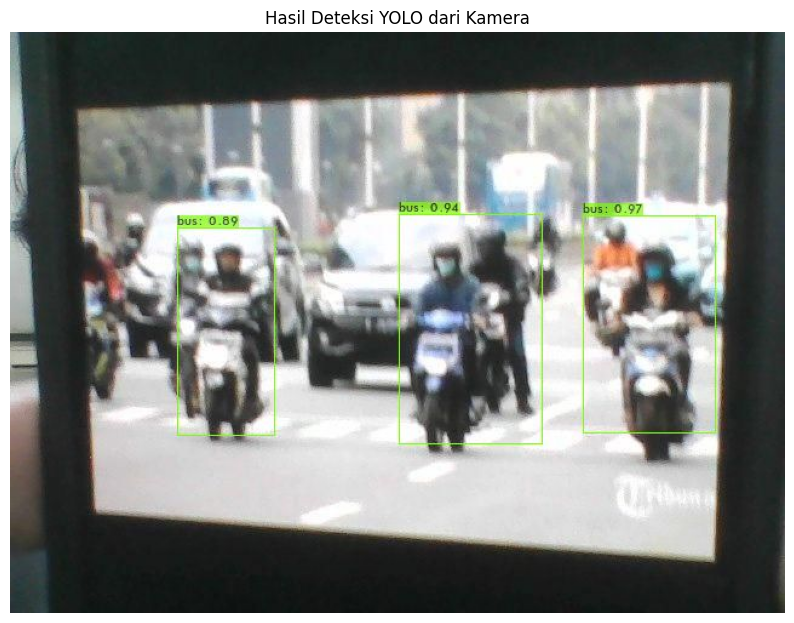

In [6]:
# Langkah 1â€“2: Ambil dan simpan foto dari kamera
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import PIL
import io
import base64
import matplotlib.pyplot as plt

def take_photo(filename='camera_capture.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'ðŸ“¸ Ambil Foto';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Tunggu tombol ditekan
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getTracks().forEach(track => track.stop());
          div.remove();

          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    img = PIL.Image.open(binary)
    img.save(filename)
    print(f'âœ… Foto disimpan ke {filename}')
    return filename

# Ambil foto
filename = take_photo()

# Tampilkan hasil gambar
img = cv2.imread(filename)
cv2_imshow(img)

# Langkah 3: Jalankan YOLO untuk deteksi objek
!./darknet detector test /content/drive/MyDrive/file_weight/obj.data \
/content/drive/MyDrive/file_weight/yolov4-tiny-custom.cfg \
/content/drive/MyDrive/file_weight/custom-yolov4-tiny-detector_best.weights \
camera_capture.jpg -dont_show

# Langkah 4: Tampilkan hasil deteksi (predictions.jpg)
pred_img = cv2.imread('predictions.jpg')
pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(pred_img_rgb)
plt.axis('off')
plt.title('Hasil Deteksi YOLO dari Kamera')
plt.show()